In [1]:
import numpy as np
from numpy.linalg import inv
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

class MetricGraph:
    def __init__(self, edges, vertex_count):
        self.edges = [(min(edge[0], edge[1]), max(edge[0], edge[1]), edge[2]) for edge in edges]
        self.graph = [{"src": s, "dst": d, "weight": w} for s, d, w in edges]
        self.weights = dict([((s, d), w) for s, d, w in edges])
        self.vertex_count = vertex_count
        self.edge_count = len(self.edges)
        self.shortest_paths = self.calculate_shortest_paths()
        self.sum_len = sum([w for s, d, w in edges])
    
    def bellman_ford(self, src: int) -> list[float]:
        distance = [float("inf")] * self.vertex_count
        distance[src] = 0.0

        for _ in range(self.vertex_count - 1):
            for j in range(self.edge_count):
                u, v, w = (self.graph[j][k] for k in ["src", "dst", "weight"])
                if distance[u] != float("inf") and distance[u] + w < distance[v]:
                    distance[v] = distance[u] + w
        return distance
    
    def calculate_shortest_paths(self) -> list[list[float]]:
        return [self.bellman_ford(src) for src in range(self.vertex_count)]
    
    def point_params(self, p):
        return min(p[0], p[1]), max(p[0], p[1]), p[2]
    
    def dist(self, p1: tuple[int, int, float], p2: tuple[int, int, float]) -> int:
        v1, v2, vx = self.point_params(p1)
        u1, u2, ux = self.point_params(p2)
        vl, ul = self.weights[(v1, v2)], self.weights[(u1, u2)]
        vy, uy = vl - vx, ul - ux # dist from v2 and u2
        
        possible_paths = []
        if v1 == u1 and v2 == u2: # same edge
            possible_paths.append(abs(vx - ux))
        possible_paths.append(vx + self.shortest_paths[v1][u1] + ux)
        possible_paths.append(vx + self.shortest_paths[v1][u2] + uy)
        possible_paths.append(vy + self.shortest_paths[v2][u1] + ux)
        possible_paths.append(vy + self.shortest_paths[v2][u2] + uy)
        return min(possible_paths)
    
    def generate_points(self, num_points: int) -> list[tuple[int, int, float]]:
        part_len = self.sum_len / num_points
        points = []
        for v, u, w in self.edges:
            points += [(v, u, part_len * i) for i in range(1, int(w / part_len))]
        return points
        
    def calculate_magnitude(self, t: float, num_points: int) -> float:
        points = self.generate_points(num_points)
        distance = np.array([[self.dist(p1, p2) for p1 in points] for p2 in points])
        exp_dist = np.exp(-distance * t)
        exp_dist_inv = np.linalg.inv(exp_dist)
        return np.sum(exp_dist_inv)
    
    def approximate_magnitude_function(self, t_vec, range_params):
        num_points_vec = np.linspace(range_params[0], range_params[1], range_params[2])
        magnitude_measures = [[self.calculate_magnitude(t, num_points) for num_points in num_points_vec] for t in t_vec]
        return magnitude_measures
    
    def plot_magnitude_function(self, t_vec, magnitude_measures, axes):
        magnitude_res = [elem[-1] for elem in magnitude_measures]
        sns.lineplot(x=t_vec, y=magnitude_res, label='experiment', color='darkred', ax=axes)
    
    def absolute_error(self, t_vec, magnitude_measures, real_values, axes):
        measure_error = [abs(elem[-1] - elem[-2]) for elem in magnitude_measures]
        magnitude_error = [abs(elem[-1] - real_values[i]) for i, elem in enumerate(magnitude_measures)]
        sns.lineplot(x=t_vec, y=measure_error, label='convergence delta', color='darkred', ax=axes)
        sns.lineplot(x=t_vec, y=magnitude_error, label='magnitude error', color='salmon', ax=axes)
        return magnitude_error
        
        
    def approx_error(self, t_vec, magnitude_measures, real_values, axes):
        measure_error = [abs(elem[-1] - elem[-2])/elem[-1] for elem in magnitude_measures]
        magnitude_error = [abs(elem[-1] - real_values[i])/elem[-1] for i, elem in enumerate(magnitude_measures)]
        sns.lineplot(x=t_vec, y=measure_error, label='approximate convergence delta', color='darkred', ax=axes)
        sns.lineplot(x=t_vec, y=magnitude_error, label='approximate magnitude error', color='salmon', ax=axes)
        return magnitude_error
    
    def plot_all(self, t_vec, magnitude_measures, real_func, real_func_name, axes):
        ax1, ax2 = axes
        t_len = [self.sum_len * t for t in t_vec]
        real_values = [real_func(t) for t in t_len]
        self.plot_magnitude_function(t_len, magnitude_measures, ax1)
        sns.lineplot(x=t_len, y=real_values, color='salmon', label=real_func_name, ax=ax1)
        print('Absolute delta:', self.absolute_error(t_len, magnitude_measures, real_values, ax2))

In [75]:
t_vec = np.linspace(10, 300, 8)

ОТРЕЗОК

Absolute delta: [0.005020822862244145, 0.028546500773565242, 0.06309697105758971, 0.11754340530998775, 0.20073991889455556, 0.32151600230665167, 0.4886689972960312, 0.7109566313766891]


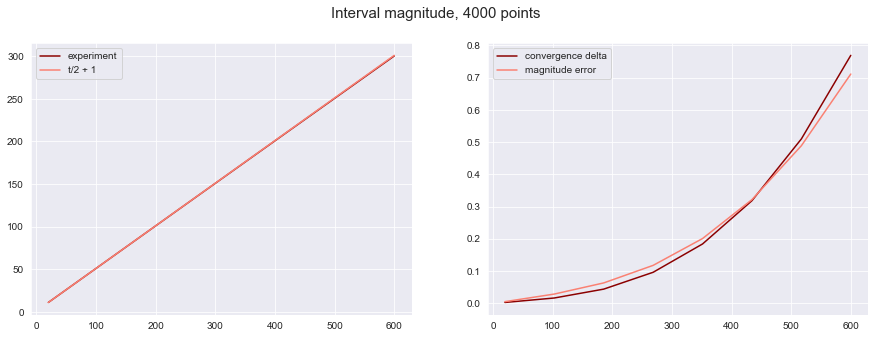

In [76]:
interval = MetricGraph(edges=[(0, 1, 2)], vertex_count=2)
magnitude_measures_interval = interval.approximate_magnitude_function(t_vec, [10, 4000, 4])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Interval magnitude, 4000 points', fontsize=15)
interval.plot_all(t_vec, magnitude_measures_interval, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.005020822862244145, 0.028546500773565242, 0.06309697105758971, 0.11754340530998775, 0.20073991889455556, 0.32151600230665167, 0.4886689972960312, 0.7109566313766891]


Text(0, 0.5, 'Delta')

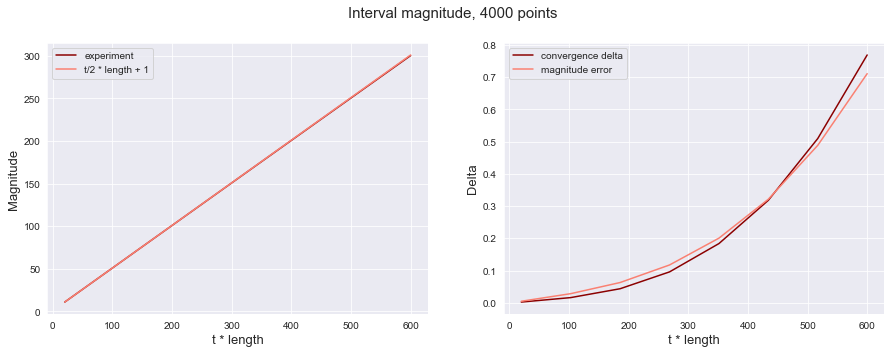

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Interval magnitude, 4000 points', fontsize=15)
interval.plot_all(t_vec, magnitude_measures_interval, lambda t: t/2 + 1, 't/2 * length + 1', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

ДЕРЕВЬЯ

In [81]:
t_vec = np.linspace(10, 120, 8)

Absolute delta: [0.03296251545467044, 0.09247373172050288, 0.17291240026152366, 0.2873443162945648, 0.44879876867173607, 0.6702541051651565, 0.9646234082212573, 1.3447403147936257]


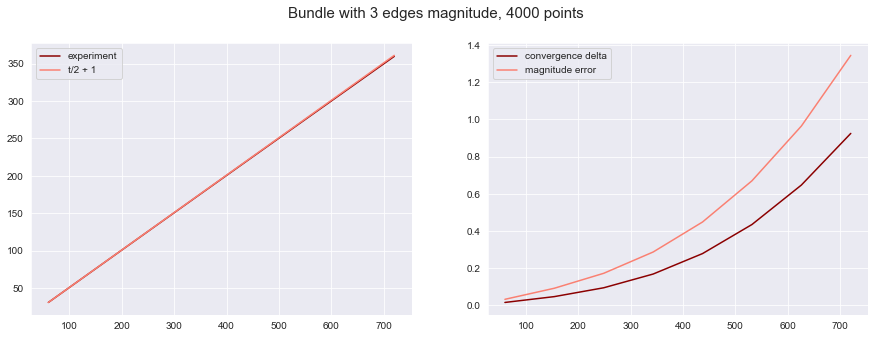

In [5]:
bundle3 = MetricGraph(edges=[(0, 1, 2), (0, 2, 3), (0, 3, 1)], vertex_count=4)
magnitude_measures_bundle3 = bundle3.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Bundle with 3 edges magnitude, 4000 points', fontsize=15)
bundle3.plot_all(t_vec, magnitude_measures_bundle3, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Text(0.5, 1.0, 'Magnitude convergence rate for t = 120')

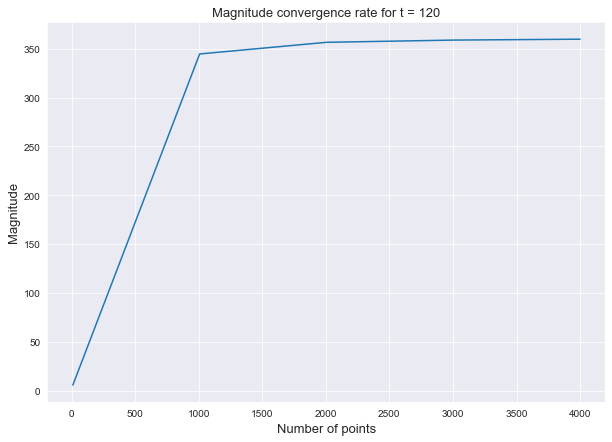

In [58]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
#sns.lineplot(x=np.linspace(10, 4000, 5), y=magnitude_measures_bundle3[0], ax=ax1)
sns.lineplot(x=np.linspace(10, 4000, 5), y=magnitude_measures_bundle3[7], ax=ax1)
np.linspace(10, 4000, 5)
ax1.set_xlabel('Number of points', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax1.set_title('Magnitude convergence rate for t = 120', fontsize=13)

Absolute delta: [0.06191198067017467, 0.17114040047246704, 0.31318518693854003, 0.5087408942954141, 0.7784242980929434, 1.1427435897045939, 1.6220678955182848, 2.2365972139740506]


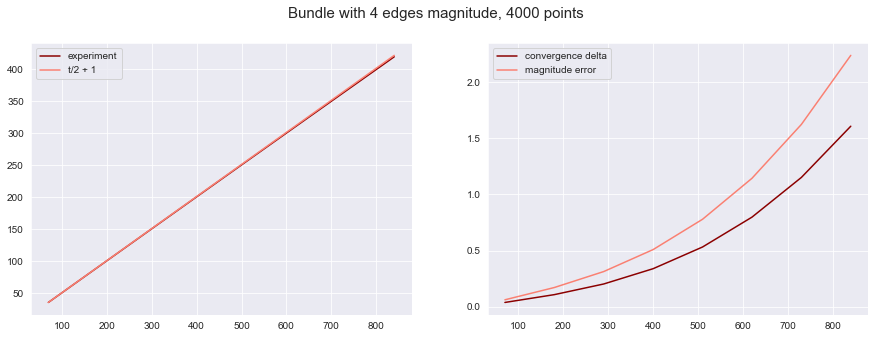

In [6]:
bundle4 = MetricGraph(edges=[(0, 1, 2), (0, 2, 3), (0, 3, 1), (0, 4, 1)], vertex_count=5)
magnitude_measures_bundle4 = bundle4.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Bundle with 4 edges magnitude, 4000 points', fontsize=15)
bundle4.plot_all(t_vec, magnitude_measures_bundle4, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.04638185272110107, 0.30570494993943953, 0.8530328123746358, 1.9272324079346959, 3.7633556066949723, 6.5907557375254555, 10.63128723641853, 16.097631954141434]


Text(0, 0.5, 'Delta')

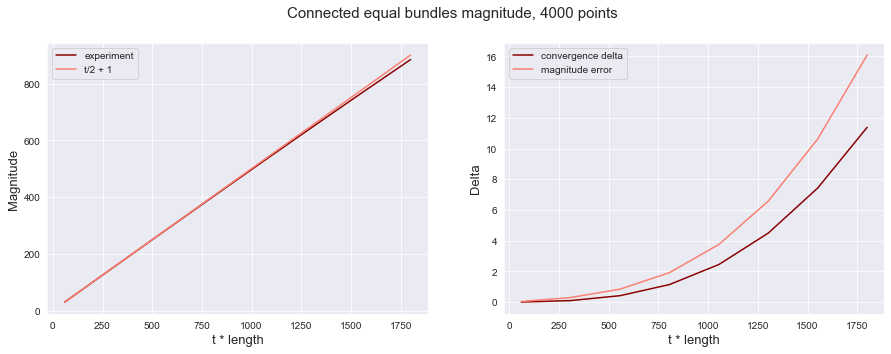

In [78]:
comb_bundle = MetricGraph(edges=[(0, 2, 1), (1, 2, 1), (3, 4, 1), (3, 5, 1), (2, 3, 2)], vertex_count=6)
magnitude_measures_comb_bundle = comb_bundle.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Connected equal bundles magnitude, 4000 points', fontsize=15)
comb_bundle.plot_all(t_vec, magnitude_measures_comb_bundle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

Absolute delta: [0.06889053284882607, 0.1878801500592715, 0.33830354020676623, 0.5409700198762266, 0.8166235093926559, 1.1859106382497657, 1.6693489580093228, 2.287295375290171]


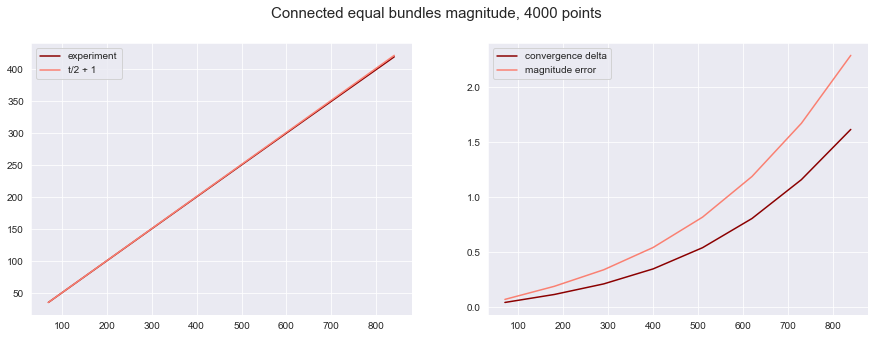

In [8]:
comb_bundle1 = MetricGraph(edges=[(0, 2, 1), (1, 2, 1), (3, 4, 1), (3, 5, 1), (3, 6, 1), (2, 3, 2)], vertex_count=7)
magnitude_measures_comb_bundle1 = comb_bundle1.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Connected equal bundles magnitude, 4000 points', fontsize=15)
comb_bundle1.plot_all(t_vec, magnitude_measures_comb_bundle1, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.06889053284882607, 0.1878801500592715, 0.33830354020676623, 0.5409700198762266, 0.8166235093926559, 1.1859106382497657, 1.6693489580093228, 2.287295375290171]


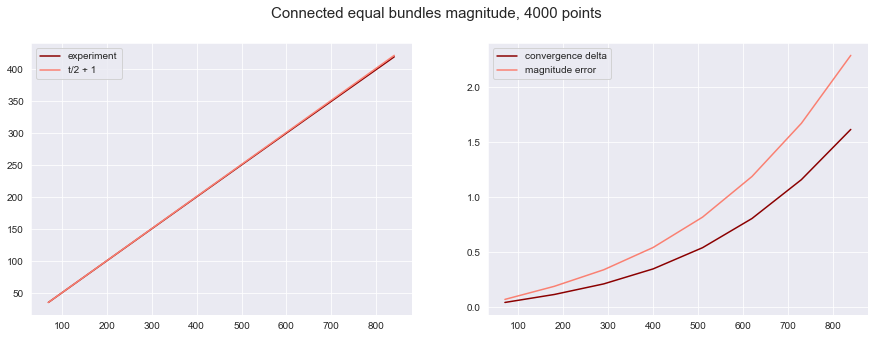

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Connected equal bundles magnitude, 4000 points', fontsize=15)
comb_bundle1.plot_all(t_vec, magnitude_measures_comb_bundle1, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

ЦИКЛ

Absolute delta: [1.0001447092781106, 1.0028463798440157, 1.0119020753948007, 1.0312277159335537, 1.0647113572668445, 1.116233948328329, 1.1896673908414641, 1.28887260899387]


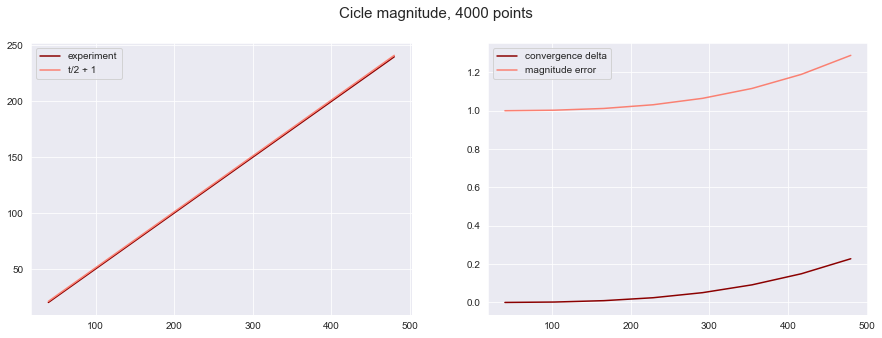

In [82]:
cicle = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1)], vertex_count=3)
magnitude_measures_cicle = cicle.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicle magnitude, 4000 points', fontsize=15)
cicle.plot_all(t_vec, magnitude_measures_cicle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.00014470927811061074, 0.0028463798440157007, 0.011902075394800704, 0.031227715933553668, 0.06471135726684452, 0.116233948328329, 0.1896673908414641, 0.28887260899387]


Text(0, 0.5, 'Delta')

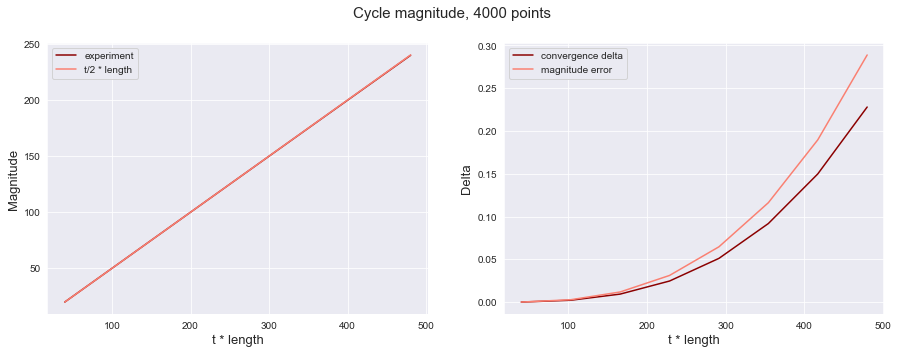

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cycle magnitude, 4000 points', fontsize=15)
cicle.plot_all(t_vec, magnitude_measures_cicle, lambda t: t/2, 't/2 * length', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

2 ЦИКЛА СКЛЕЕННЫЕ ПО ВЕРШИНЕ

Absolute delta: [2.0112518366140932, 2.040657232374471, 2.1025854344593427, 2.2181462840148356, 2.408294199925564, 2.6938727044741313, 3.095580911798379, 3.633940535358761]


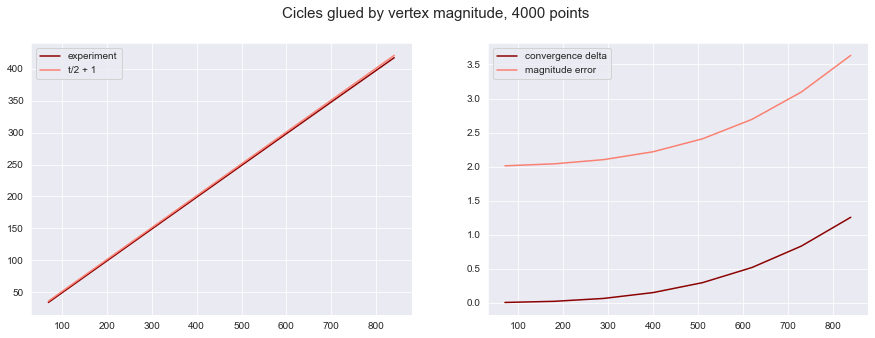

In [11]:
eight_cicle = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1), (2, 3, 1), (3, 4, 1), (2, 4, 1)], vertex_count=5)
magnitude_measures_eight_cicle = eight_cicle.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by vertex magnitude, 4000 points', fontsize=15)
eight_cicle.plot_all(t_vec, magnitude_measures_eight_cicle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [2.0112518366140932, 2.040657232374471, 2.1025854344593427, 2.2181462840148356, 2.408294199925564, 2.6938727044741313, 3.095580911798379, 3.633940535358761]


Text(0, 0.5, 'Delta')

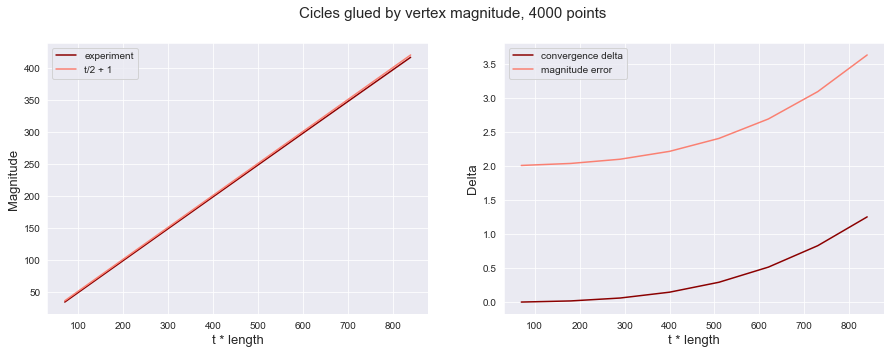

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by vertex magnitude, 4000 points', fontsize=15)
eight_cicle.plot_all(t_vec, magnitude_measures_eight_cicle, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

Absolute delta: [0.011251836614093236, 0.040657232374471164, 0.10258543445934265, 0.2181462840148356, 0.4082941999255638, 0.6938727044741313, 1.095580911798379, 1.6339405353587608]


Text(0, 0.5, 'Delta')

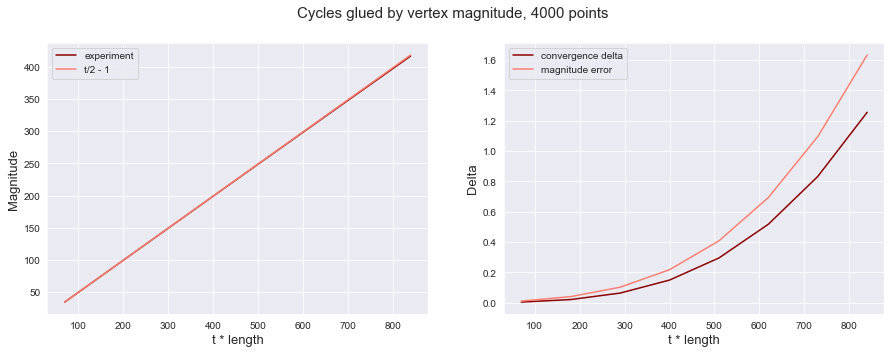

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cycles glued by vertex magnitude, 4000 points', fontsize=15)
eight_cicle.plot_all(t_vec, magnitude_measures_eight_cicle, lambda t: t/2 - 1, 't/2 - 1', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

ЦИКЛ С ПРИКРЕПЛЕННЫМИ ДЕРЕВЬЯМИ

2 ЦИКЛА СКЛЕЕННЫЕ ПО РЕБРУ

Absolute delta: [2.009975118805805, 2.0509990678130237, 2.1622611269510514, 2.388533892083956, 2.7742543980827463, 3.3634457198843393, 4.199596577139403, 5.32554535799909]


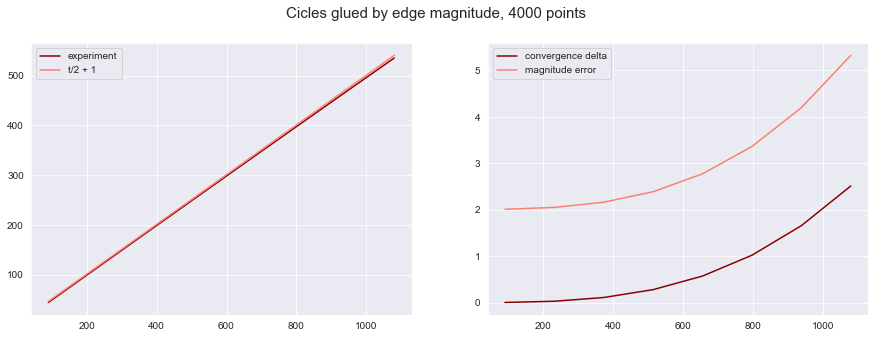

In [13]:
rhombus = MetricGraph(edges=[(0, 1, 1), (0, 2, 4), (1, 2, 1), (0, 3, 1), (2, 3, 2)], vertex_count=4)
magnitude_measures_rhombus = rhombus.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus.plot_all(t_vec, magnitude_measures_rhombus, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [1.009975118805805, 1.2901337616652313, 2.5651798909613603, 5.6360357818171, 11.270936804846883, 20.192292837619675, 33.06572843468007, 50.49151252195179]


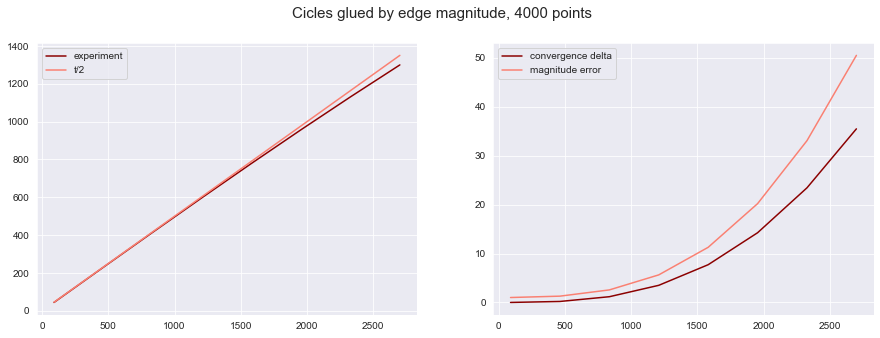

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus.plot_all(t_vec, magnitude_measures_rhombus, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [0.009975118805805039, 0.05099906781302366, 0.16226112695105144, 0.38853389208395583, 0.7742543980827463, 1.3634457198843393, 2.1995965771394026, 3.32554535799909]


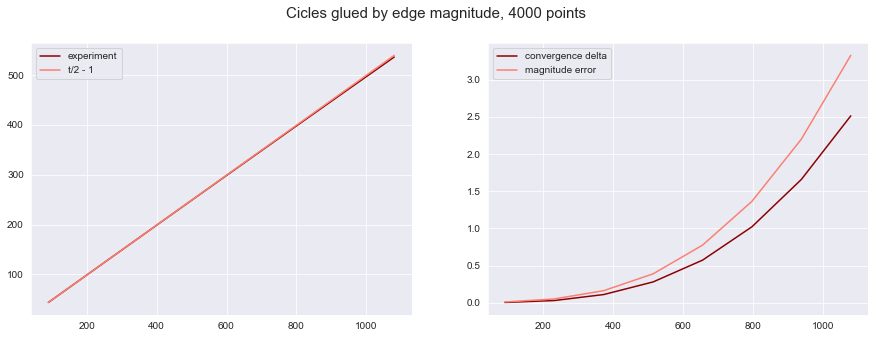

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus.plot_all(t_vec, magnitude_measures_rhombus, lambda t: t/2 - 1, 't/2 - 1', (ax1, ax2))

3 ЦИКЛА СКЛЕЕННЫЕ ПО ВЕРШИНЕ

Absolute delta: [3.0323021758468442, 3.125667974526209, 3.312352153996926, 3.655895353213168, 4.216395219992194, 5.053272318062625, 6.225090322211258, 7.789381237576663]


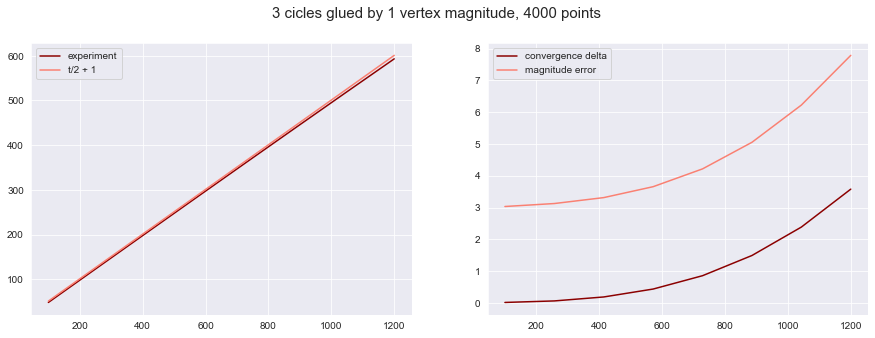

In [16]:
flower = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1), (0, 3, 1), (0, 4, 1), (3, 4, 1), (0, 5, 1), (0, 6, 0.5), (5, 6, 1.5)], vertex_count=7)
magnitude_measures_flower = flower.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [2.0323021758468442, 2.125667974526209, 2.312352153996926, 2.655895353213168, 3.2163952199921937, 4.053272318062625, 5.225090322211258, 6.789381237576663]


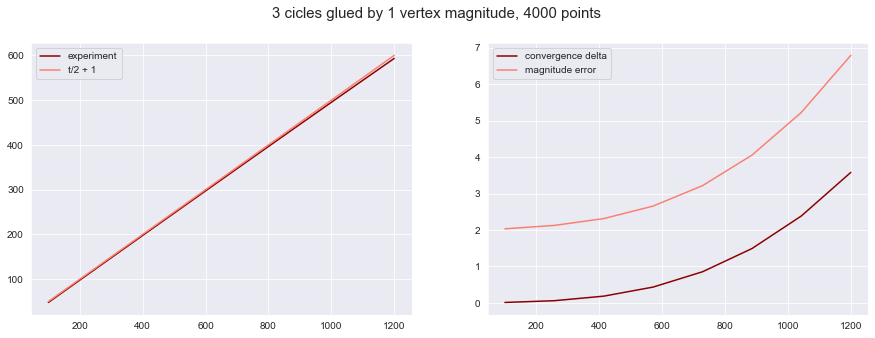

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2, 't/2 + 1', (ax1, ax2))

Absolute delta: [1.0323021758468442, 1.125667974526209, 1.312352153996926, 1.6558953532131682, 2.2163952199921937, 3.053272318062625, 4.225090322211258, 5.789381237576663]


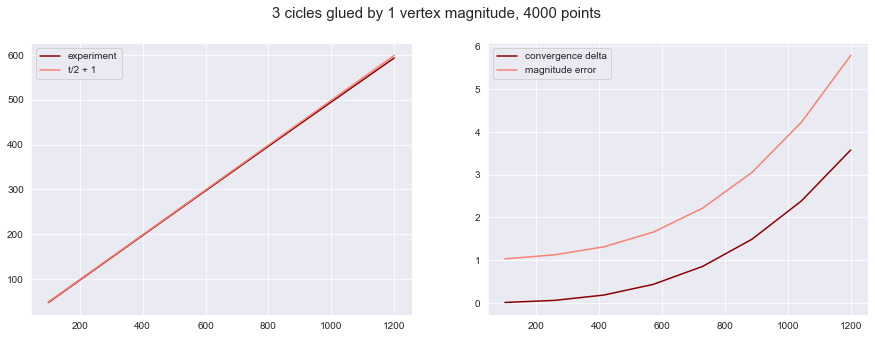

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2 - 1, 't/2 + 1', (ax1, ax2))

Absolute delta: [0.03230217584684425, 0.12566797452620904, 0.31235215399692606, 0.6558953532131682, 1.2163952199921937, 2.053272318062625, 3.2250903222112584, 4.789381237576663]


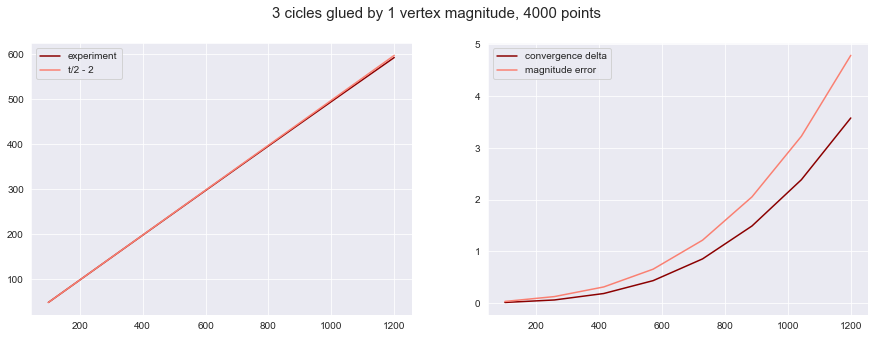

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 vertex magnitude, 4000 points', fontsize=15)
flower.plot_all(t_vec, magnitude_measures_flower, lambda t: t/2 - 2, 't/2 - 2', (ax1, ax2))

3 ЦИКЛА СКЛЕЕННЫЕ ПО ОДНОМУ РЕБРУ

Absolute delta: [3.0206224333786835, 3.0702207708828553, 3.1677086830931103, 3.3442525121894846, 3.630754046622485, 4.057905802934897, 4.656130856845948, 5.45552374963961]


Text(0, 0.5, 'Delta')

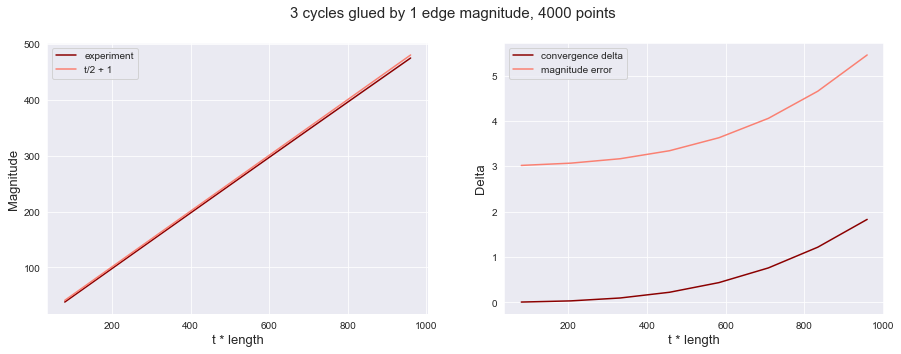

In [86]:
triangles = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (1, 2, 1), (0, 3, 1), (1, 3, 1), (0, 4, 1), (1, 4, 1)], vertex_count=5)
magnitude_measures_triangles = triangles.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cycles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2 + 1, 't/2 + 1', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

Absolute delta: [2.0206224333786835, 2.0702207708828553, 2.1677086830931103, 2.3442525121894846, 2.630754046622485, 3.057905802934897, 3.656130856845948, 4.45552374963961]


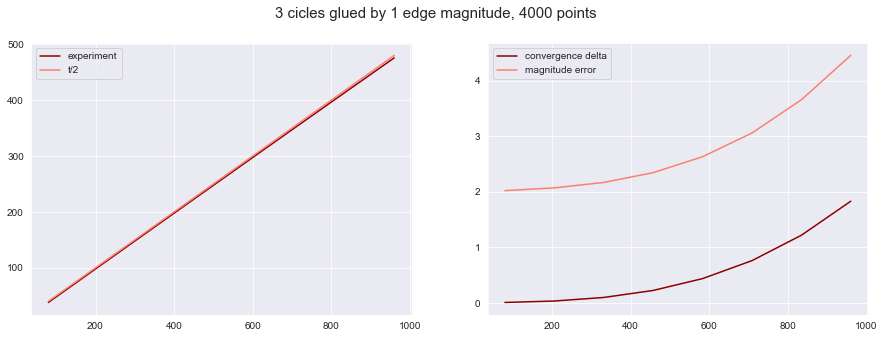

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [1.0206224333786835, 1.0702207708828553, 1.1677086830931103, 1.3442525121894846, 1.630754046622485, 2.057905802934897, 2.656130856845948, 3.4555237496396103]


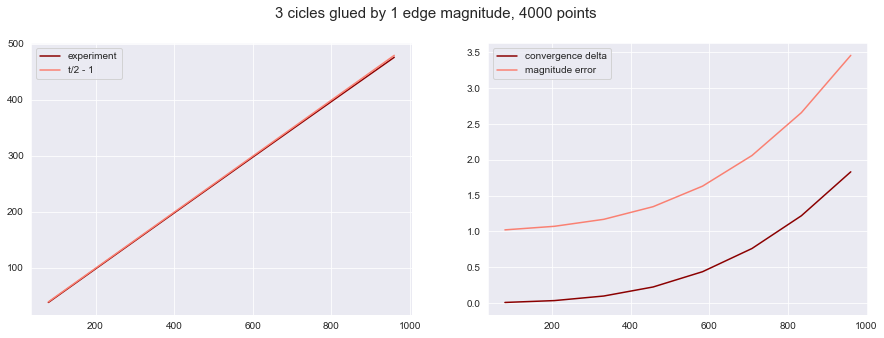

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2 - 1, 't/2 - 1', (ax1, ax2))

Absolute delta: [0.020622433378683525, 0.07022077088285528, 0.16770868309311027, 0.3442525121894846, 0.630754046622485, 1.057905802934897, 1.656130856845948, 2.4555237496396103]


Text(0, 0.5, 'Delta')

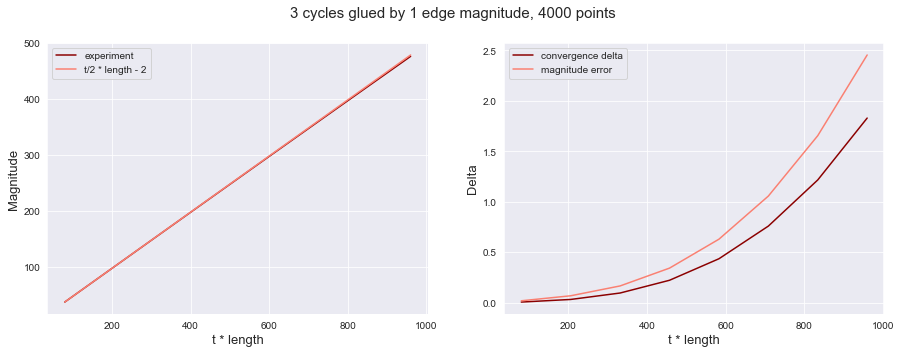

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cycles glued by 1 edge magnitude, 4000 points', fontsize=15)
triangles.plot_all(t_vec, magnitude_measures_triangles, lambda t: t/2 - 2, 't/2 * length - 2', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

3 ЦИКЛА СКЛЕЕННЫЕ ПО РАЗНЫМ РЕБРАМ (1)

Absolute delta: [2.0275385244872552, 2.1145069381327914, 2.326681429755979, 2.74584451312262, 3.452978825489822, 4.528003238635563, 6.049440446075096, 8.094098269713072]


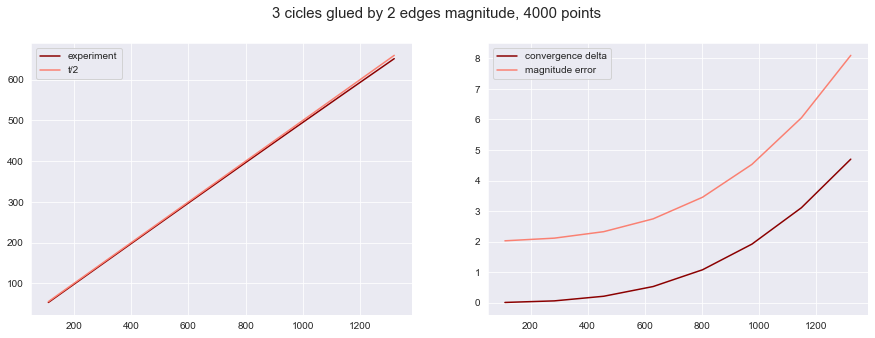

In [25]:
triangles2edges = MetricGraph(edges=[(0, 1, 1), (1, 2, 2), (2, 3, 1), (3, 4, 1), (0, 4, 2), (0, 2, 1), (0, 3, 3)], vertex_count=5)
magnitude_measures_triangles2edges = triangles2edges.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 2 edges magnitude, 4000 points', fontsize=15)
triangles2edges.plot_all(t_vec, magnitude_measures_triangles2edges, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [0.027538524487255245, 0.11450693813279145, 0.326681429755979, 0.7458445131226199, 1.4529788254898222, 2.528003238635563, 4.049440446075096, 6.094098269713072]


Text(0, 0.5, 'Delta')

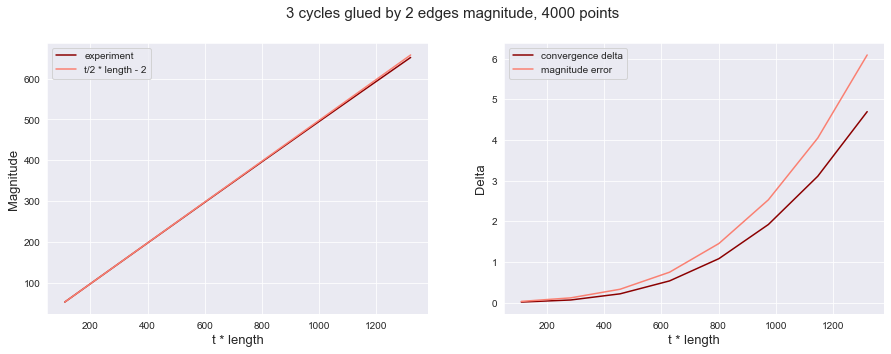

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cycles glued by 2 edges magnitude, 4000 points', fontsize=15)
triangles2edges.plot_all(t_vec, magnitude_measures_triangles2edges, lambda t: t/2 - 2, 't/2 * length - 2', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

3 ЦИКЛА СКЛЕЕННЫЕ ПО РАЗНЫМ РЕБРАМ (2)

Absolute delta: [2.0186993504324775, 2.0703651597368236, 2.1882331788217186, 2.4170270794039084, 2.8011729905733773, 3.3847607904372126, 4.211422741242757, 5.324213275192847]


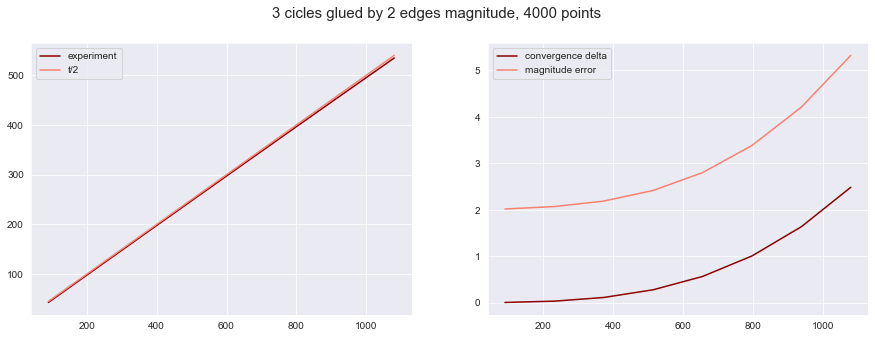

In [27]:
full3 = MetricGraph(edges=[(0, 1, 1), (0, 2, 2), (0, 3, 1), (1, 2, 1), (1, 3, 3), (2, 3, 1)], vertex_count=4)
magnitude_measures_full3 = full3.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cicles glued by 2 edges magnitude, 4000 points', fontsize=15)
full3.plot_all(t_vec, magnitude_measures_full3, lambda t: t/2, 't/2', (ax1, ax2))

Absolute delta: [0.0186993504324775, 0.07036515973682356, 0.18823317882171864, 0.4170270794039084, 0.8011729905733773, 1.3847607904372126, 2.2114227412427567, 3.3242132751928466]


Text(0, 0.5, 'Delta')

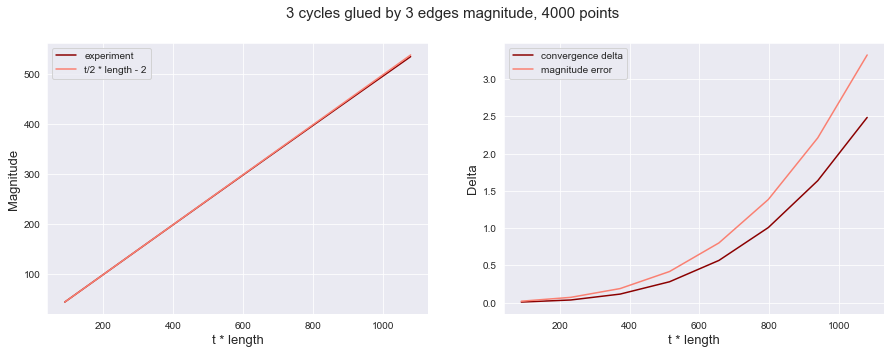

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('3 cycles glued by 3 edges magnitude, 4000 points', fontsize=15)
full3.plot_all(t_vec, magnitude_measures_full3, lambda t: t/2 - 2, 't/2 * length - 2', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)

СЛУЧАЙНЫЙ ГРАФ ДЛЯ ПРОВЕРКИ ГИПОТЕЗЫ

Absolute delta: [0.12575271859851256, 0.1463878055883896, 0.2901288296857558, 0.49668798697402394, 0.8000958524955877, 1.2289831270430227, 1.8115157514868656, 2.575539663278107]
438.42952704429626


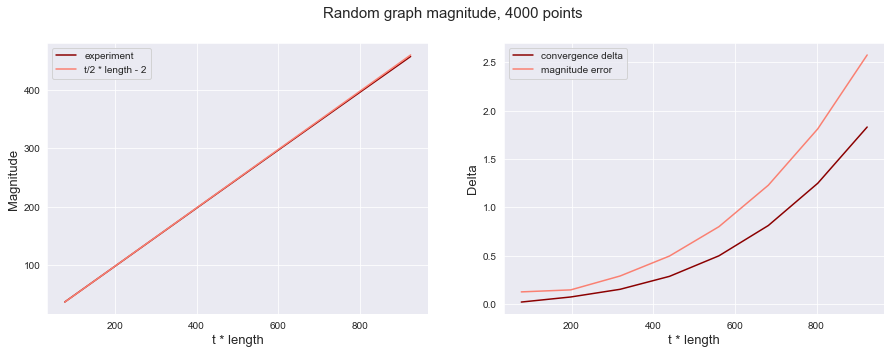

In [94]:
b = time.time()
random = MetricGraph(edges=[(0, 1, 0.5), (0, 3, 0.2), (0, 5, 1), (0, 7, 1), (0, 8, 0.3), (1, 2, 0.4), (1, 3, 0.2), (2, 3, 1), (4, 5, 0.1), (5, 6, 1), (7, 8, 2)], vertex_count=9)
magnitude_measures_random = random.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Random graph magnitude, 4000 points', fontsize=15)
random.plot_all(t_vec, magnitude_measures_random, lambda t: t/2 - 2, 't/2 * length - 2', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)
e = time.time()
print(e - b)

Absolute delta: [0.021790631285412587, 0.177393704192923, 0.6629836825699726, 1.683388895076007, 3.4395907336136133, 6.127281648561507, 9.935481333396524, 15.045283004917337]


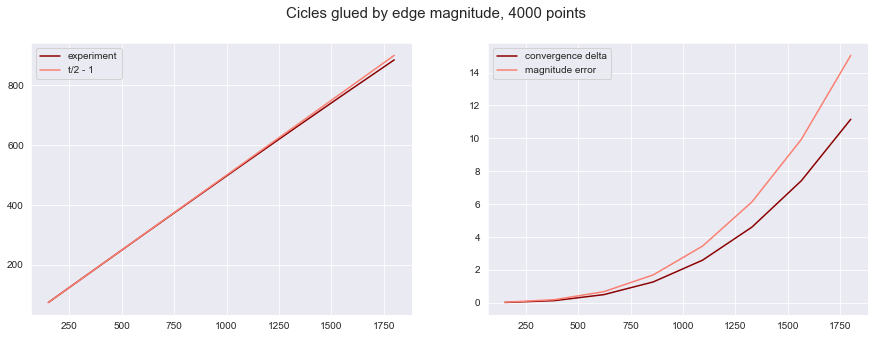

In [62]:
rhombus1 = MetricGraph(edges=[(0, 1, 1), (0, 2, 10), (1, 2, 1), (0, 3, 1), (2, 3, 2)], vertex_count=4)
magnitude_measures_rhombus1 = rhombus1.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus1.plot_all(t_vec, magnitude_measures_rhombus1, lambda t: t/2 - 1, 't/2 - 1', (ax1, ax2))

Absolute delta: [0.0024505466118043273, 0.01925291932107598, 0.0487306272861332, 0.10399547530823838, 0.19521592903433316, 0.3325273674035145, 0.5260231504054786, 0.7857446415024469]


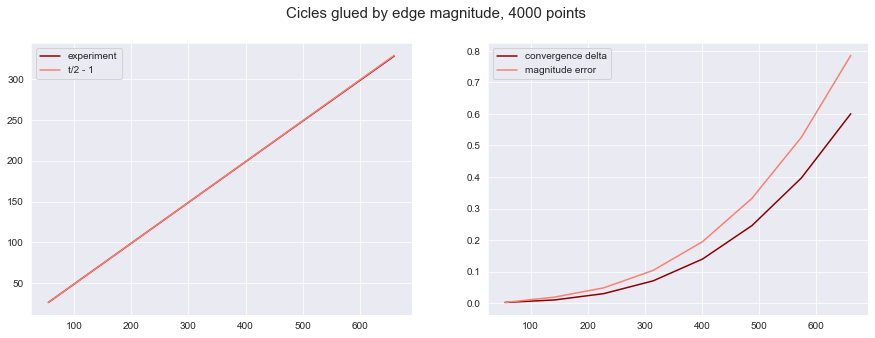

In [63]:
rhombus2 = MetricGraph(edges=[(0, 1, 1), (0, 2, 0.5), (1, 2, 1), (0, 3, 1), (2, 3, 2)], vertex_count=4)
magnitude_measures_rhombus2 = rhombus2.approximate_magnitude_function(t_vec, [10, 4000, 5])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus2.plot_all(t_vec, magnitude_measures_rhombus2, lambda t: t/2 - 1, 't/2 - 1', (ax1, ax2))

Absolute delta: [0.0024505466118043273, 0.01925291932107598, 0.0487306272861332, 0.10399547530823838, 0.19521592903433316, 0.3325273674035145, 0.5260231504054786, 0.7857446415024469]


Text(0, 0.5, 'Delta')

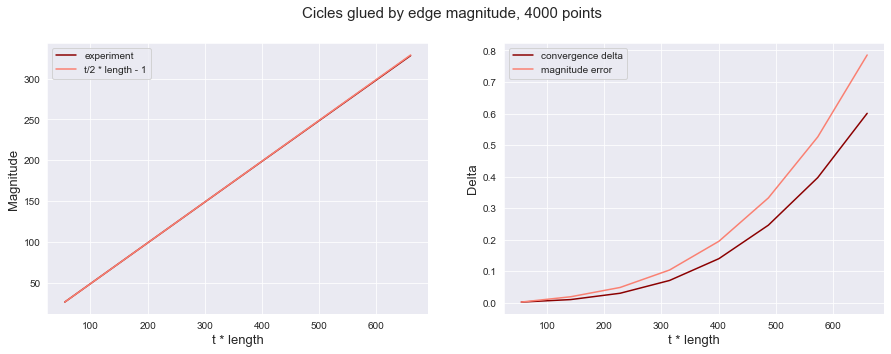

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Cicles glued by edge magnitude, 4000 points', fontsize=15)
rhombus2.plot_all(t_vec, magnitude_measures_rhombus2, lambda t: t/2 - 1, 't/2 * length - 1', (ax1, ax2))
ax1.set_xlabel('t * length', fontsize=13)
ax1.set_ylabel('Magnitude', fontsize=13)
ax2.set_xlabel('t * length', fontsize=13)
ax2.set_ylabel('Delta', fontsize=13)